In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot # # # the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data 


In [10]:
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earliest_date[0]} , Latest: {latest_date[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


In [11]:
# Calculate the date 1 year ago from the last data point in the database
latestdate = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation '])
precipitation = precipitation.dropna(how='any') # clean up non value entries
precipitation = precipitation.set_index("Date")
# Sort the dataframe by date
precipitation = precipitation.sort_values(["Date"], ascending=True)

precipitation.head()
plt.savefig("images/precipitation_by_date.png")


<Figure size 432x288 with 0 Axes>

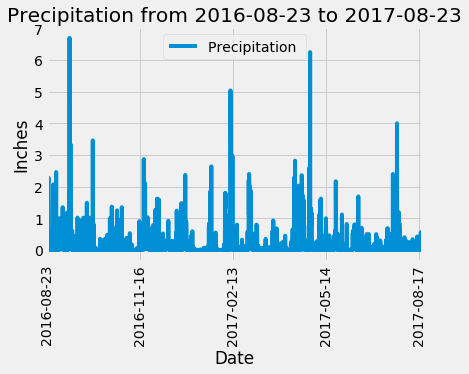

<Figure size 432x288 with 0 Axes>

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation.plot(rot=90)
plt.title(f"Precipitation from {querydate} to {latest_date[0]}")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

plt.savefig("images/Precipitation.png")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count() # id is the primary key

9

In [15]:
""" What are the most active stations? (i.e. what stations have the most rows)?
List the stations and the counts in descending order."""

sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
""" Using the station id from the previous query, calculate the lowest temperature recorded, 
 highest temperature recorded, and average temperature of the most active station?"""
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station_data = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
list(most_active_station_data )

[54.0, 85.0, 71.66378066378067]

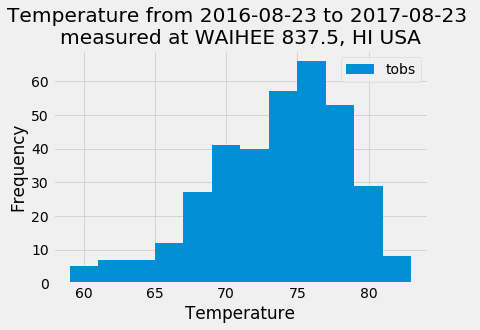

In [17]:
"""Choose the station with the highest number of temperature observations.
Query the last 12 months of temperature observation data for this station and plot the results as a histogram """
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == activestations[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel("Temperature")
plt.title(f"Temperature from {querydate} to {latest_date[0]} \nmeasured at {stationname}A")
plt.legend()
plt.savefig("images/Temperature.png")

# Temperature Analysis

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = dt.date(2018, 1, 1) - dt.timedelta(days=365)
enddate = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tempresult = calc_temps(startdate.strftime("%Y-%m-%d"), enddate.strftime("%Y-%m-%d"))[0]
tempresult

(62.0, 68.36585365853658, 74.0)

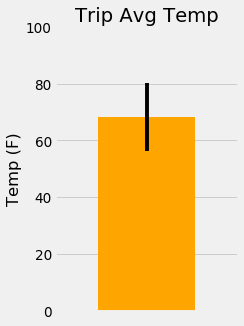

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
startdate = '2017-01-01'
enddate = '2017-01-07'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations_df = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
print(stations_df)


       Station                                    Name  Latitude  Longitude  \
0  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
1  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   
2  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130 -157.83740   
3  USC00513117                    KANEOHE 838.1, HI US  21.42340 -157.80150   
4  USC00519281                     WAIHEE 837.5, HI US  21.45167 -157.84889   
5  USC00519397                    WAIKIKI 717.2, HI US  21.27160 -157.81680   

   Elevation  PrcpSum  
0       19.5     0.61  
1      152.4     0.60  
2        7.0     0.60  
3       14.6     0.35  
4       32.9     0.20  
5        3.0     0.00  
